# 第三部：第1回日本人工知能オリンピック (JOAI2025) に挑戦しよう


## 概要


### 第３部のゴール

- 画像分類AIを「動かして・学習させて・予測させる」体験をする
- すべてのコードを完全に理解する必要はありません
- 特に以下の部分や**詳しいコードの意味については「今は雰囲気でOK」です**
  - timm の中身
  - ニューラルネットワークの内部構造
  - optimizer や loss の数学的意味

今日は、「データ → モデル → 学習 → 予測 → 提出」という **全体の流れを掴むことがゴールです**

今後、ChatGPT などのLLMを利用して自習するためのきっかけとしてもらい、JOAI2026に参加できるようになることを目的としています。


### 今回扱うタスク：JOAI2025 について

今日は、第1回日本人工知能オリンピック (JOAI2025) と同じお題を触って、AIについて学びます。

本番と同様の形式の問題は [Playground JOAI Competition 2025](https://www.kaggle.com/competitions/playground-joai-competition-2025/overview) で公開されています。

**課題の内容**

与えられるデータは次の 3 種類です：

- 表形式データ（数値情報）: センサ測定値の数値データ
- 画像データ: 赤外線カメラで撮影された画像
- テキストデータ: 画像に関する説明テキスト

これら 3 つの情報を組み合わせて、ガスの状態を分類するモデルを作り、正しく予測できるかを競います。

**何を予測するのか**

モデルが予測するのは 4クラス分類問題 です。
ガスの状態は次の4つに分類されます：

- NoGas（ガスなし）
- Perfume（香水）
- Smoke（煙）
- Mixed（香水と煙の混合）

![image](https://drive.google.com/uc?id=1_TnMQXtGD6r9T4XbIej0F-Y_N7xdYw1x)


## Step 0: 事前準備


### Runtimeの変更

今回扱う画像用のAIは計算量が多く、通常のマシンだと実行に非常に時間がかかります。
そこで、GPUと呼ばれるハードウェアを使うことで短時間で実行することが可能になります。

Colaboratoryでは簡単にGPUを利用することができるので、これを利用できるように設定しておきましょう。

GPUが使えなくてもエラーにはなりませんが、非常に実行が遅くなってしまいます。

※ 今回はデフォルトで T4 というGPUを使う設定になっています

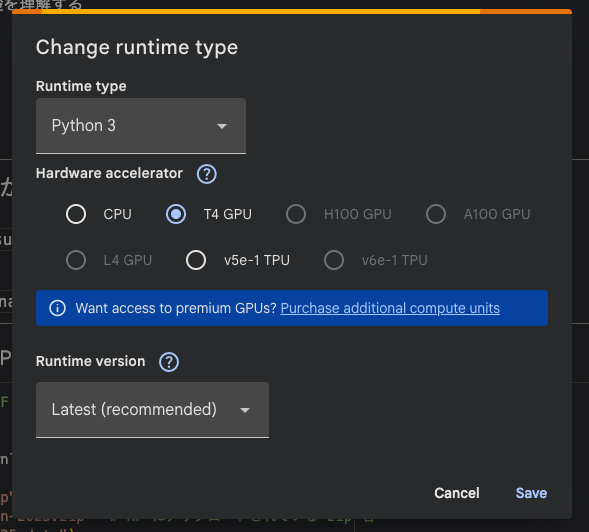


### データの取得

今回は [JOAI2025](https://www.kaggle.com/competitions/playground-joai-competition-2025/overview) で用いられたデータを使います

- CSV: `train.csv`, `test.csv`, `sample_submission.csv`
- 画像: `images/` フォルダ

Hugging Face Hub というデータ置き場から **必要なファイル** を取得しています。

※ コードの中身は詳しく理解できてなくてもOKです

![image](https://drive.google.com/uc?id=1IA7RVz_PWhGt7j_BMdiDRISMjyF5BmL3)


In [ ]:
from pathlib import Path
import zipfile
from huggingface_hub import hf_hub_download

REPO_ID = "kami634/joai2025-dataset-zip"
ZIP_NAME = "playground-joai-competition-2025.zip"  # HF にアップロードされている zip 名
LOCAL_DATA_DIR = Path("/content/joai2025_data")

LOCAL_DATA_DIR.mkdir(parents=True, exist_ok=True)

# 展開後に存在すべきファイル・ディレクトリ
required = ["train.csv", "test.csv", "sample_submission.csv", "images"]


def is_extracted_ok(base: Path, required_items):
    return all((base / r).exists() for r in required_items)


if is_extracted_ok(LOCAL_DATA_DIR, required):
    print("Dataset already extracted:", LOCAL_DATA_DIR)
else:
    # zip を HF Hub からダウンロード
    zip_path = hf_hub_download(
        repo_id=REPO_ID,
        repo_type="dataset",
        filename=ZIP_NAME,
    )

    print("Downloaded zip:", zip_path)

    # zip を展開
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(LOCAL_DATA_DIR)

    print("Extracted to:", LOCAL_DATA_DIR)

# 簡易チェック
print("Top-level files:", sorted([p.name for p in LOCAL_DATA_DIR.iterdir()]))
image_dir = LOCAL_DATA_DIR / "images"
if image_dir.exists():
    print("Image samples:", len(list(image_dir.glob("*"))))
else:
    print("images/ directory not found")

Dataset already extracted: \content\joai2025_data
Top-level files: ['images', 'sample_submission.csv', 'test.csv', 'train.csv']
Image samples: 6400


c:\1BelltreeTech\Python\AI-Olympic\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## データ格納先確認
print(LOCAL_DATA_DIR)
!ls $LOCAL_DATA_DIR

\content\joai2025_data


'ls' �́A�����R�}���h�܂��͊O���R�}���h�A
����\�ȃv���O�����܂��̓o�b�` �t�@�C���Ƃ��ĔF������Ă��܂���B


## Step 1: 探索的データ解析(EDA: Explanatory Data Analysis)

探索的データ解析（Exploratory Data Analysis, EDA）　とは、データを詳しく調べ、その全体像や隠れたパターン、問題点を発見するための分析のことです。 初期段階にデータの概要を把握するために行ったり、データ分析やモデル改善を進める上で出てきた仮説を検証するためにデータを可視化したりすることもあります。

ここでは、データ分析について詳しくない方でもJOAI2025の選考に用いられるデータの概要を把握し、その後自身でEDAを進められるようになることを目標とします。


### 分析前の準備

まず必要なライブラリを読み込みます。
KaggleやColaboratory環境上では、データ分析に必要な基本的なライブラリは既にインストール済みなので、今回使うものはimportするだけで使えます。

これらのライブラリは使っていくうちに覚えるものなので、今は理解できなくて問題ありません。


In [3]:
import textwrap
from pathlib import Path

# 数値計算やデータ操作に使うライブラリ
import numpy as np
import pandas as pd

# 画像を扱うためのライブラリ
from PIL import Image

import matplotlib.pyplot as plt
import plotly as py
import plotly.express as px
import plotly.io as pio

CSV という形式で提供されているデータを読み込みます。
CSVは「データの一覧表」です。

今回のCSVには、

- 画像ファイルの名前
- 正解ラベル

などが書かれています。

まずは **どんな情報が入っているかを見る** ことが大切です。

データ分析ではpandasかPolarsと呼ばれるライブラリを使うことが多いです。\
今回は解説記事などが豊富なpandasを用いることにします。


In [4]:
COMPETITION_DATA_DIR = LOCAL_DATA_DIR  # Kaggle互換の変数名で統一

train_df = pd.read_csv(COMPETITION_DATA_DIR / "train.csv")
test_df = pd.read_csv(COMPETITION_DATA_DIR / "test.csv")
sample_submission_df = pd.read_csv(COMPETITION_DATA_DIR / "sample_submission.csv")

### 基本情報の確認

中身を一つずつ確認していきます。

csv データは以下のように表形式のデータとなっています:

- 行＝データ1件
- 列＝特徴量（情報）

まずは head() メソッドを利用して最初の５行分を確認していきましょう。


In [ ]:
print("【trainデータ】")
display(train_df.head())
print()

print("【testデータ】")
display(test_df.head())
print()

print("【sample submission】")
display(sample_submission_df.head())
print()

【trainデータ】


,MQ8,MQ5,Caption,image_path_uuid,Gas
0,632,418,Thermal image shows a wall with a door. The do...,5cb1edca7cc74a88accb1b14416acb73.png,NoGas
1,567,392,Thermal image shows a mostly uniform temperatu...,968e732e317743199e527c2552eed0c3.png,Perfume
2,562,393,Thermal image shows a mostly uniform temperatu...,1ce9142c26c24c51a0dfcdb4b9b50810.png,Perfume
3,352,441,The thermal image shows a mostly uniform tempe...,c4c3e61df66645109f17e1484a37b0d9.png,Mixture
4,603,412,Thermal image shows a temperature range from 1...,9c65bdff9add4c52a24a5228719272f8.png,Perfume



【testデータ】


,MQ8,MQ5,Caption,image_path_uuid
0,621,345,"Thermal image shows a temperature gradient, wa...",072b9da436c94fd5b464fc567e49c8a6.png
1,718,457,The thermal image shows varying temperatures a...,76ccd4d4f14148a6a68073b2b370e868.png
2,640,414,"Thermal image shows a uniformly green field, i...",677566ae802c40dd94b67f73ebfb4788.png
3,710,485,Thermal image shows areas of higher temperatur...,5084a734263c4265a0a38657577bb76d.png
4,361,438,The thermal image shows a mostly uniform tempe...,116f9c19ef574ffb9674b8a78a2d1d1a.png



【sample submission】


,index,Gas
0,0,NoGas
1,1,NoGas
2,2,NoGas
3,3,NoGas
4,4,NoGas


今回は、trainデータを使ってモデルを学習・検証し、testデータの Gas カラムを予測することになります。
sample submissionは提出例になります。

全体の行数やカラム数も確認してみましょう。


In [ ]:
# データの形状

print("【trainデータ】", train_df.shape)
print()

print("【testデータ】", test_df.shape)
print()

print("【sample submission】", sample_submission_df.shape)
print()

【trainデータ】 (5760, 5)

【testデータ】 (640, 4)

【sample submission】 (640, 2)



testデータとsample submissionの行数が640行で同一になっていますね。
今回提出するのはテストデータに対して予測した sample_submission.csv と同様の形式のcsvファイルになり、作成したcsvファイルをKaggle上で提出すると自動でスコアリングされます。

trainデータとtestデータは似たような内容なので、以降は簡単のためにtrainデータに絞って分析していきます。


### ターゲットの確認

今回予測したい Gas カラムについて簡単に確認しておきましょう。


In [ ]:
# ターゲット変数 'Gas' の分布を可視化するためのヒストグラム（棒グラフ）を作成
fig = px.histogram(
    train_df,
    x="Gas",
    color="Gas",
    title="trainデータにおけるターゲット Gas の分布",
    labels={"Gas": "Gas", "count": "件数"},
)

# グラフの表示
fig.show()

### 数値特徴量の確認

数値で表現された特徴量として'MQ8'と'MQ5'というカラムがあります。
まずはこれらのデータについて確認してみましょう。

describe()メソッドを用いると数値特徴量の基本統計量をまとめて計算することができます。
つまり、そのデータの、最大値・最小値・平均値・分散・四分位数などの情報を得られます。


In [ ]:
train_df[["MQ8", "MQ5"]].describe()

,MQ8,MQ5
count,5760.000000,5760.000000
mean,542.342361,404.696875
std,151.082710,55.707096
min,220.000000,291.000000
25%,446.000000,366.000000
50%,576.000000,400.000000
75%,642.000000,443.000000
max,794.000000,596.000000


大体の大きさがこれでわかりました。
数値情報をニューラルネットワークのinputにする際は、大きい値や特徴量ごとに大きさが違う値をそのまま使うとうまくいかないことが多いので、0付近や1付近になるように値をスケールさせることが多いので注意しておきましょう。


データの分布も見ておきましょう。


In [ ]:
fig = px.histogram(train_df, x="MQ8", title="trainデータにおけるMQ8の分布")
fig.show()

In [ ]:
fig = px.histogram(train_df, x="MQ5", title="trainデータにおけるMQ5の分布")
fig.show()

もしかしたらターゲットごとに分布に特徴があるかもしれません。ターゲットごとに色を分けて可視化してみます。


In [ ]:
fig = px.histogram(train_df, x="MQ8", color="Gas", title="trainデータにおけるMQ8の分布")
fig.show()

In [ ]:
fig = px.histogram(train_df, x="MQ5", color="Gas", title="trainデータにおけるMQ5の分布")
fig.show()

ターゲットのクラスごとにかなりの偏りがあります。数値情報は予測するうえで重要な情報ということが分かるでしょう。


MQ5とMQ8同士の関係も可視化してみます。


In [ ]:
fig = px.density_heatmap(
    train_df, x="MQ8", y="MQ5", marginal_x="histogram", marginal_y="histogram"
)

fig.show()

クラスごとに上記の可視化をしてみても面白いかもしれません。


### テキストや画像情報の可視化

データ中に含まれるテキスト情報や画像情報の中身を確認してみます。

全て確認するのは大変なので、ターゲットのクラスごとに三サンプルずつ見てみましょう。


Class: NoGas


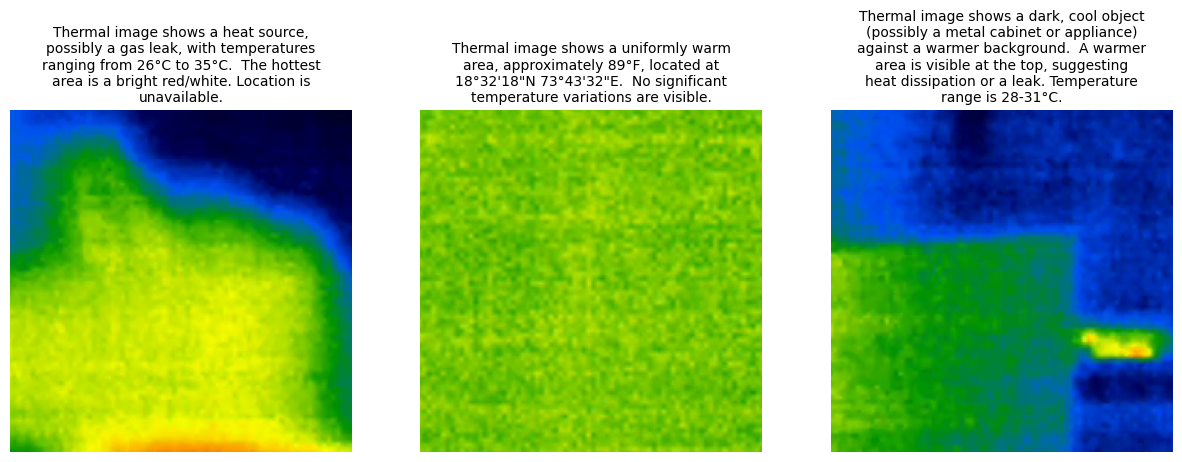

Class: Perfume


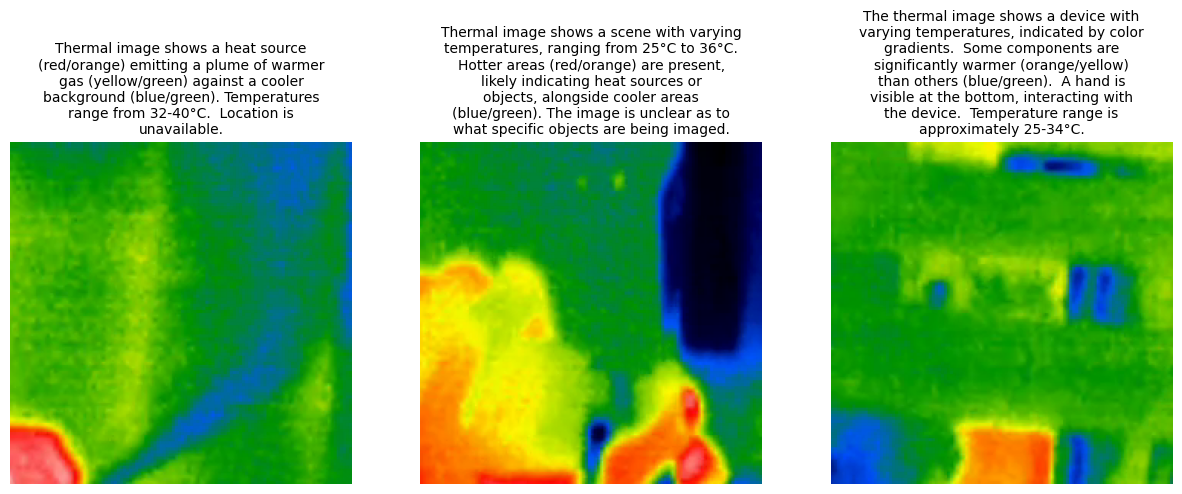

Class: Mixture


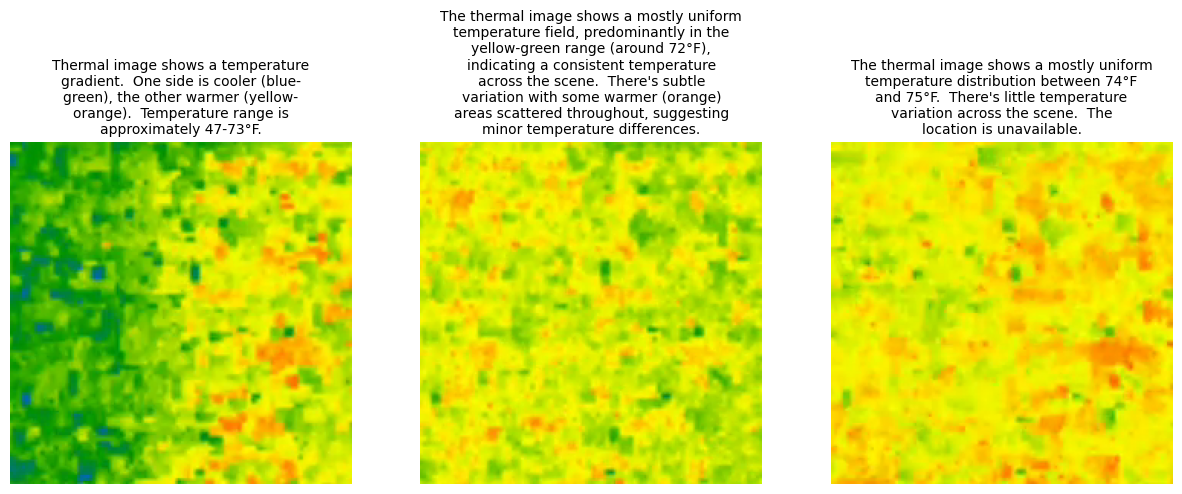

Class: Smoke


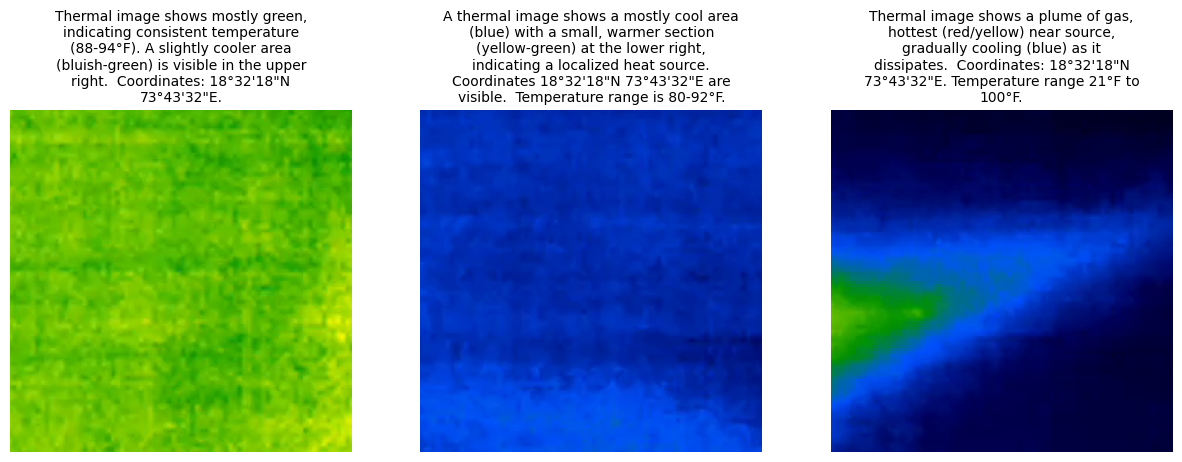

In [ ]:
n_samples = 3

image_dir = COMPETITION_DATA_DIR / "images"

for cls in train_df["Gas"].unique():
    class_df = train_df[train_df["Gas"] == cls]
    sample_df = class_df.sample(
        n=min(n_samples, len(class_df)), random_state=42
    ).reset_index(drop=True)

    print(f"Class: {cls}")
    plt.figure(figsize=(5 * len(sample_df), 5))

    for i, row in sample_df.iterrows():
        plt.subplot(1, len(sample_df), i + 1)
        img = Image.open(image_dir / row["image_path_uuid"]).convert("RGB")
        plt.imshow(img)
        plt.axis("off")
        caption_wrapped = textwrap.fill(row["Caption"], width=40)
        plt.title(caption_wrapped, fontsize=10)

    plt.show()

---
---


## Step 2: 機械学習チュートリアル

以降は、AIや機械学習が初めての方でも、一通り基礎的な知識を抑えて課題に取り組み始められるような解説し、ベースとなるコードを提供します。

今回のタスクでは色々なアプローチが考えられますが、今回は画像を用いてAIで学習・推論ができるようになることを目指します。


### AIとは

人工知能（AI: Artificial Intelligence）は、コンピューターが人間のような知能的な行動や思考をできるようにする技術の総称のことで、非常に広い概念です。ChatGPTのようなものだけではなく、単純なルールに基づいたアルゴリズムもAIと呼ばれることもあります。

今回はその中でも「機械学習」と呼ばれる、一番AIのイメージに近いものを取り扱います。

### 機械学習（Machine Learning）とは

機械学習とは、「大量のデータからパターンを自動的に学習し、未来のデータに対して予測や判断を行う手法」のことです

犬と猫の写真をたくさん見せて、「これは犬だ」「これは猫だ」とラベルを付けておくと、AIが「犬の特徴」や「猫の特徴」を学んで、新しい画像も正しく分類できるようになります。

今回はガス等の画像を使って、「これはガスが含まれてない」「これは煙だ」というのを予測することになります。

![image](https://drive.google.com/uc?id=1ntZtrM92tzdpkhg3eyPRIbkIrbmZUQ8D)


### ニューラルネットワーク（Neural Network）

実際の機械学習におけるAI本体(モデル)は、入力に対して出力を返す関数のようなものになっています。

とりわけ、人間の脳の神経細胞（ニューロン）のつながりに形が似ているものはニューラルネットワークと呼ばれます。内部で数値(パラメータ)を持っており、入力された数値にその数値をかけたり足したりすることで、最終的な答えを出力します。

このニューラルネットワーク等の層を沢山重ねるものを特に「ディープラーニング（Deep Learning）」と呼びます。

### 学習の流れ

学習することで、ニューラルネットワークが持つパラメータを少しずつ更新することで、入力に対して正しい出力が返ってくるようにします。

正解があるデータ学ぶ（教師あり学習）のときは、以下のような流れで学習します。

1. 入力：画像（例えば猫の写真）
2. 予測：AIが「これは犬かも？」と判断
3. 正解と比較：「本当は猫だった！」という答えと比べる
4. 間違いの大きさを測る（損失関数）
5. 間違いの大きさに応じて、パラメータを少しだけ調整（誤差逆伝播法＋最適化アルゴリズム）

![image](https://drive.google.com/uc?id=1Is-1Uf_FwG_H9GSFXmJOmRnjjYhtxJM4)


### JOAI2025のタスクの確認

今回のタスクは、ガスについての以下の情報:

- MQ8,MQ5 の数値情報
- Caption の言語情報
- image_path_uuid の画像情報

からGasカラムに含まれる値 ("Mixture","NoGas","Perfume","Smoke"のどれなのか) を予測することになります。

https://www.kaggle.com/competitions/playground-joai-competition-2025/overview

train.csv のデータで学習をして、test.csv のデータに対する予測結果を最終的に提出することになります。

以下のようにtestデータの値を確認してみると、Gas カラムが存在しないことがわかります。


In [15]:
COMPETITION_DATA_DIR = LOCAL_DATA_DIR  # Kaggle互換の変数名で統一

train_df = pd.read_csv(COMPETITION_DATA_DIR / "train.csv")
test_df = pd.read_csv(COMPETITION_DATA_DIR / "test.csv")
sample_submission_df = pd.read_csv(COMPETITION_DATA_DIR / "sample_submission.csv")

In [ ]:
print("【testデータ】", test_df.shape)
print(test_df.head())

【testデータ】 (640, 4)
   MQ8  MQ5                                            Caption  \
0  621  345  Thermal image shows a temperature gradient, wa...   
1  718  457  The thermal image shows varying temperatures a...   
2  640  414  Thermal image shows a uniformly green field, i...   
3  710  485  Thermal image shows areas of higher temperatur...   
4  361  438  The thermal image shows a mostly uniform tempe...   

                        image_path_uuid  
0  072b9da436c94fd5b464fc567e49c8a6.png  
1  76ccd4d4f14148a6a68073b2b370e868.png  
2  677566ae802c40dd94b67f73ebfb4788.png  
3  5084a734263c4265a0a38657577bb76d.png  
4  116f9c19ef574ffb9674b8a78a2d1d1a.png  


### 準備

まずは必要なライブラリのインポートや、学習時に利用する数値を事前に定義しておきます。

ライブラリというのは、便利な機能をまとめて提供してくれる「道具箱」のようなものです。たとえば、数字の計算を手軽に行えるようにしてくれるライブラリや、グラフを描いてデータをわかりやすく見せてくれるライブラリなど、さまざまな種類があります。

Pythonで機械学習をするときによく使われるライブラリとしては、以下のようなものがあります。

- NumPy: 高速に数値計算を行うための機能がそろっている
- pandas/Polars: 表形式のデータを扱いやすくするための機能がそろっている
- matplotlib: グラフを作成するためのライブラリ
- scikit-learn: 機械学習のアルゴリズムがそろっていて、簡単な実装で学習ができる
- Pytorch: GPUでの数値計算やニューラルネットワークの学習やできる


In [ ]:
import os
import random
import numpy as np

import timm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from dataclasses import dataclass


def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True


seed_everything(42)

ModuleNotFoundError: No module named 'timm'

後で使いやすくなるように設定などを一つにまとめて定義しておきます。 この段階では細かいところは理解できていなくても構いません。


In [ ]:
NUM_CLASSES = 4
TARGET_COL = "Gas"

NAME2LABEL = {"Mixture": 0, "NoGas": 1, "Perfume": 2, "Smoke": 3}
LABEL2NAME = {v: k for k, v in NAME2LABEL.items()}


@dataclass
class EnvConfig:
    data_dir: Path = COMPETITION_DATA_DIR
    image_dir: Path = data_dir / "images"
    train_path: Path = data_dir / "train.csv"
    test_path: Path = data_dir / "test.csv"
    model_save_dir: Path = Path("/content/output")

    def __init__(self):
        self.model_save_dir.mkdir(parents=True, exist_ok=True)


@dataclass
class ExpConfig:
    seed: int = 42
    num_folds: int = 5
    batch_size: int = 32
    num_epochs: int = 2
    learning_rate: float = 1e-4
    num_workers: int = 2
    img_model_name: str = "resnet50.a1h_in1k"
    img_pretrained: bool = True
    img_size: int = 224


@dataclass
class Config:
    env = EnvConfig()
    exp = ExpConfig()

機械学習では、いくつかの数値（batch_sizeやlearning_rateなど）を指定して学習し、モデルの重み（パラメータ）を更新していくことになります。

モデルの重み（パラメータ）との違いが分かるように、configでセットしたようなパラメータはハイパーパラメータなどと呼びます。

今回はハイパーパラメータをPythonのdataclassでまとめて管理しておくことで、ハイパーパラメータを変更したときの「モデルの学習→性能チェック」がやりやすくなるようにしています。

![image](https://drive.google.com/uc?id=1lYR5RpGSHp18z8R33tuJ3aXyf2VuSlcK)

中身を確認してみましょう。


In [ ]:
# Configクラスのインスタンスを作成（env, exp両方の設定が読み込まれる）
cfg = Config()

# ExpConfigのseedを参照してみる
cfg.exp.seed  # 42という値が取得できる

42

### モデルの定義

実際に今回学習するモデルを定義してみましょう。

timm というライブラリを使うと、既にある画像用の機械学習用モデルを簡単に定義することができます。オープンなデータセットで事前に学習済みのモデルを利用することも可能です。

今回は４クラス分類をすることになるので、以下のように定義します。


In [ ]:
class GasModel(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.model = timm.create_model(
            cfg.exp.img_model_name,
            pretrained=cfg.exp.img_pretrained,
            num_classes=NUM_CLASSES,
        )

    def forward(self, x):
        return self.model(x)


model = GasModel(cfg)
sum(p.numel() for p in model.parameters())

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

23516228

実際のモデルの中身は畳み込みなどを利用した複雑な構造になっています。


In [ ]:
# modelを表示すると中身の構造が見れる
model

GasModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momen

では試しに、今回の画像を入力に、このモデルの出力を確認してみましょう。

以下の画像をモデルに入力してみます。


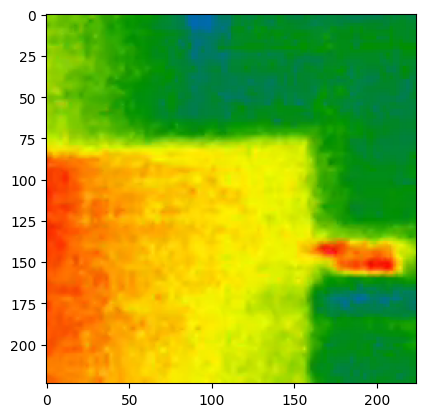

In [ ]:
# テスト用の画像ファイルパス（NoGasというカテゴリの画像）
img_path = f"{LOCAL_DATA_DIR}/images/5cb1edca7cc74a88accb1b14416acb73.png"

# 画像を開いてRGB形式に変換（Grayscaleの可能性を排除するため）
img = Image.open(img_path).convert("RGB")

# 画像を表示する（Jupyter Notebooksでのみ有効）
plt.imshow(img)

### 補足：画像を数値として表現する

画像はコンピュータにとって数値の集まりです。ここではその仕組みを簡単に説明します。

画像は「ピクセル」と呼ばれる小さな点の集まりでできています。例えば「1920×1080」という解像度は、横に1920個、縦に1080個のピクセルがあるという意味です。 そして各ピクセルの色は「RGB値」という3つの数字で表されます：

- R (赤): 0〜255
- G (緑): 0〜255
- B (青): 0〜255
  例えば、真っ赤な色は[255, 0, 0]、白は[255, 255, 255]、黒は[0, 0, 0]です。

そして1つのピクセルが3つの値を持っていて、それが高さx幅の分の数値を持つことになるため、画像全体は高さ×幅×3(RGB)の3次元配列として表されます。

例えば400×300ピクセルのカラー画像なら(400, 300, 3)の形状になります

![image](https://github.com/go5paopao/work_box_img/blob/main/tutorial_img/img_tensor_small.png?raw=true)


モデルに入力できる形式にして入力してみましょう。


In [ ]:
# 画像をTensor（数値配列）に変換し、色の平均や明るさを調整（正規化）する処理
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# 変換した画像に「バッチ」という次元を1つ加える (1, C, H, W)
x = transform(img).unsqueeze(0)

# モデルを推論モードにして（勾配計算をしない）
model.eval()
with torch.no_grad():
    # 画像データをモデルに渡して、予測結果を取得
    output = model(x)

# 予測結果（クラスごとのスコアなど）が表示される
output

tensor([[-0.0707,  0.0825,  0.0333,  0.1273]])

これでこの画像の4クラスに対する予測値が出ました。これはそのままだと確率として扱えないので、softmaxという処理を用いて確率として扱います


In [ ]:
# カテゴリ名（Mixture, NoGas, Perfume, Smoke）とラベル番号の対応を確認
print(NAME2LABEL)

# モデルの生出力をsoftmax関数で確率(0から1の間の数字で、クラスの合計が1.0になる)に変換
output.softmax(dim=1)

{'Mixture': 0, 'NoGas': 1, 'Perfume': 2, 'Smoke': 3}


tensor([[0.2225, 0.2593, 0.2469, 0.2712]])

これで、NAME2LABELの各クラスに対する確率が得られました。 しかし、これは学習していない状態なので、出力も適当になっています。

モデルを学習することでこの値が正解に近づくようにしていきます。


### Dataset

PyTorch で学習を行う場合は、`Dataset`と呼ばれるクラスを定義する必要があります。
Datasetは「データを1個ずつ取り出すための箱」です。

今回は

- 画像を1枚ずつ
- 正解ラベルとセットで

取り出して学習するために用います。

これは、PyTorchで提供されている`DataLoader`と呼ばれるクラスで、ミニバッチと呼ばれる塊ごとにデータを取得するために必要なものになります。


In [ ]:
class TrainGasDataset(Dataset):
    def __init__(self, cfg: Config, df: pd.DataFrame):
        self.cfg = cfg
        self.df = df.reset_index(drop=True)

        self.transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(size=cfg.exp.img_size, scale=(0.9, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        # 「番号を渡すと、データが返ってくる関数」
        row = self.df.iloc[index]
        img_path = self.cfg.env.image_dir / row["image_path_uuid"]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        label = NAME2LABEL[row[TARGET_COL]]
        return image, label


# このクラスを使って、学習用のデータセットを作成
train_dataset = TrainGasDataset(cfg, train_df)

RandomResizedCropの指定は、画像サイズを一定にするとともに"データオーグメンテーション"と呼ばれるもののために指定しています。全く同じ画像を何度も学習させるのではなく、少し変わった画像を入力して学習することで汎化性能を向上させることができます。

RandomHorizontalFlipなど他のものも試して性能がどうなるか確認してみるのも良いでしょう。


Datasetはindexを指定することで要素を取得することができます。


In [ ]:
# 学習用データセットの最初の要素を取り出して、画像とラベルに分割
image, label = train_dataset[0]

# 画像の形状 (チャンネル数、高さ、幅) と ラベル番号を確認
image.shape, label

(torch.Size([3, 224, 224]), 1)

In [ ]:
# 今度は同様に10番目のindexを指定
image, label = train_dataset[10]
image.shape, label

(torch.Size([3, 224, 224]), 0)

DataLoaderを使ってミニバッチごとにデータを取得するには以下のようにします。
以下では32個ごとのまとまりをミニバッチとしています。


In [ ]:
# DataLoaderを使って、Datasetから決まった数（バッチサイズ）ごとにデータを取得
# shuffle=True でデータをランダムな順番に並べ替え
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ミニバッチ単位で画像とラベルを取り出す
for image, label in train_loader:
    # 今回のバッチに含まれる画像数やサイズを確認
    print(image.shape)
    # ラベル（正解クラスの番号）を確認
    print(label)
    break  # 最初のバッチだけ表示して終了

torch.Size([32, 3, 224, 224])
tensor([3, 0, 0, 1, 1, 0, 2, 2, 0, 1, 2, 2, 2, 1, 3, 2, 0, 3, 1, 1, 3, 0, 2, 0,
        2, 3, 2, 2, 0, 2, 3, 2])


### 検証について

多くの場合、データは学習(train)データと検証(validation)データにさらに分割し、モデルの性能を正しく評価できるようにします。

学習データで評価してしまうと、学んだことのあるデータに対する予測なので過度に高く性能が評価されてしまい、汎化しているかどうかを評価することができません。

![image](https://drive.google.com/uc?id=1WBBO6WWu6ue-UkBlzicYFdx2mZcmD-Mf)

#### 交差検証（クロスバリデーション）

train.csvを学習用と検証用に更に分割することになると、データがさらに減ってしまいます。

そこで、データ全体をkグループに分割し、そのうちのk-1グループを学習データ・１グループを検証データとすることで、k回学習・評価をすることができます。

全てのデータを検証データとして１回扱うことができるので、手元でより正しくモデルの性能を評価するのに用いられています。

全てのタスクで使えるわけではなく、時間情報などを含んだデータを取り扱う場合は未来のデータを学習データに用いてしまうと「リーク」してしまうので注意が必要です。

![image](https://drive.google.com/uc?id=1mD4Kk8KVxTRhUFsH7n2yEPKYsQKZJyfn)


今回は、`fold` カラムにグループの番号を含めるようにしました。

今回は、`StratifiedKFold`を利用してグループ分けを行うこで、各クラスが均等にグループに分割されるようにしています。この検証戦略をどうするのかも、信頼できる検証スコアを得るためにタスクごとに考える必要があり、機械学習・データ分析の重要な部分の一つといえるでしょう。


In [ ]:
def prepare_folds(train_df: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    """
    StratifiedKFoldを使って、train_dfにfoldカラム（交差検証の番号）を追加する
    """
    # データ数だけ用意した配列をfold番号で埋める
    fold_array = np.zeros(len(train_df), dtype=np.int32)

    # StratifiedKFold: ラベルのバランスを保ちながら複数の分割を作る
    skf = StratifiedKFold(
        n_splits=cfg.exp.num_folds, shuffle=True, random_state=cfg.exp.seed
    )

    # valid_idxに該当するデータにfold番号を割り当てる
    for fold, (_, valid_idx) in enumerate(skf.split(train_df, train_df[TARGET_COL])):
        fold_array[valid_idx] = fold

    # 元のDataFrameにfoldカラムを追加して返す
    train_df["fold"] = fold_array
    return train_df


# train_dfにfold列を追加（交差検証で使う）
train_df = prepare_folds(train_df, cfg)
train_df.head()

,MQ8,MQ5,Caption,image_path_uuid,Gas,fold
0,632,418,Thermal image shows a wall with a door. The do...,5cb1edca7cc74a88accb1b14416acb73.png,NoGas,0
1,567,392,Thermal image shows a mostly uniform temperatu...,968e732e317743199e527c2552eed0c3.png,Perfume,1
2,562,393,Thermal image shows a mostly uniform temperatu...,1ce9142c26c24c51a0dfcdb4b9b50810.png,Perfume,4
3,352,441,The thermal image shows a mostly uniform tempe...,c4c3e61df66645109f17e1484a37b0d9.png,Mixture,4
4,603,412,Thermal image shows a temperature range from 1...,9c65bdff9add4c52a24a5228719272f8.png,Perfume,4


実際にクロスバリデーションでの学習・検証を行う例を見てみましょう。


### 学習・検証

学習の流れ（ざっくり）:

1. データを少しずつ取り出す
2. モデルに入れる
3. 間違いを計算する
4. モデルを少し修正する

これを何回も繰り返します。

今回は各foldごとに`cfg.exp.num_epochs`回全ての学習用データを学習します。


In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    # モデルを学習モードに切り替え（ドロップアウトなどが有効になる）
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc="Training"):
        # GPUやCPUに合わせてデータを転送
        images, labels = images.to(device), labels.to(device)
        # 前のバッチ分の勾配をリセット
        optimizer.zero_grad()
        # モデルに画像を入力して予測を出す
        outputs = model(images)
        # 予測と正解ラベルとの誤差を計算
        loss = criterion(outputs, labels)
        # 逆伝播を行ってパラメータを更新
        loss.backward()
        optimizer.step()
        # 今バッチの損失を合計
        total_loss += loss.item()
    # 全バッチの平均損失を返す
    return total_loss / len(train_loader)


def validate(model, valid_loader, criterion, device):
    # モデルを評価モードに切り替え（ドロップアウトなどが固定になる）
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    # 評価時は勾配の計算を行わない
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # 予測が一番高いクラスを取り出す
            predicted = outputs.argmax(dim=1)
            # 正解数を足していく
            total_correct += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)

            # 後でF1スコアを計算するために、予測と正解をリストに追加
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # バリデーションセット全体の平均損失、正解率、F1スコアを計算
    avg_loss = total_loss / len(valid_loader)
    accuracy = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return avg_loss, accuracy, f1


def train_fold(fold: int, train_df: pd.DataFrame, cfg: Config, device):
    print(f"\n{'*' * 20}\nFold {fold}")

    # 指定したfold以外を学習データ、それをfoldとする部分を検証データに
    train_fold_df = train_df[train_df["fold"] != fold].reset_index(drop=True)
    valid_fold_df = train_df[train_df["fold"] == fold].reset_index(drop=True)

    # データセットとデータローダーの準備（学習用と検証用）
    train_dataset = TrainGasDataset(cfg, train_fold_df)
    valid_dataset = TrainGasDataset(cfg, valid_fold_df)
    train_loader = DataLoader(
        train_dataset,
        batch_size=cfg.exp.batch_size,
        shuffle=True,
        num_workers=cfg.exp.num_workers,
        pin_memory=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=cfg.exp.batch_size,
        shuffle=False,
        num_workers=cfg.exp.num_workers,
        pin_memory=True,
    )

    # モデルをGPU/CPUへ、損失関数と最適化手法を設定
    model = GasModel(cfg).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg.exp.learning_rate)

    # 指定のエポック数だけ、学習と検証を繰り返す
    for epoch in range(cfg.exp.num_epochs):
        print(f"Epoch {epoch}")
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        valid_loss, valid_accuracy, valid_f1 = validate(
            model, valid_loader, criterion, device
        )
        print(
            f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | "
            f"Valid Accuracy: {valid_accuracy:.4f} | Valid F1: {valid_f1:.4f}"
        )

    # エポック終了後のモデルを保存（チェックポイント）
    model_save_path = (
        cfg.env.model_save_dir / f"fold{fold}_epoch{cfg.exp.num_epochs - 1}.pth"
    )
    torch.save(model.state_dict(), model_save_path)
    print(f"Model for fold {fold} saved to {model_save_path}")

In [ ]:
# CPUとGPUのどちらを使うかを自動判定（CUDAが使える環境ならGPUを使う）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 複数のfoldがあるが、今回は時間節約のためfold=0だけを実行
for fold in range(cfg.exp.num_folds):
    train_fold(fold, train_df, cfg, device)
    break  # fold=0でループ終了


********************
Fold 0
Epoch 0


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.8407 | Valid Loss: 0.4245 | Valid Accuracy: 0.8464 | Valid F1: 0.8465
Epoch 1


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.3833 | Valid Loss: 0.3733 | Valid Accuracy: 0.8472 | Valid F1: 0.8480
Model for fold 0 saved to /content/output/fold0_epoch1.pth


### 推論・提出ファイル作成


In [ ]:
class TestGasDataset(Dataset):
    def __init__(self, cfg: Config, df: pd.DataFrame):
        self.cfg = cfg
        self.df = df
        # テスト時はリサイズだけ行い、拡張はしない
        self.transform = transforms.Compose(
            [
                transforms.Resize(224),  # 224x224の大きさに変換
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    def __len__(self):
        # テストデータ全体のサンプル数
        return len(self.df)

    def __getitem__(self, index):
        # 画像ファイルのパスを取得
        img_path = self.cfg.env.image_dir / self.df["image_path_uuid"][index]
        # 画像を読み込み、RGBに変換
        image = Image.open(img_path).convert("RGB")
        # 変換（リサイズ、テンソル化、正規化）を適用
        image = self.transform(image)
        return image


def run_inference(cfg: Config, device):
    print("\nStarting Inference")
    # テスト用のDataFrameを読み込む
    test_df = pd.read_csv(cfg.env.test_path)
    # テスト用DatasetとDataLoaderを作成
    test_dataset = TestGasDataset(cfg, test_df)
    test_loader = DataLoader(
        test_dataset,
        batch_size=cfg.exp.batch_size,
        shuffle=False,
        num_workers=cfg.exp.num_workers,
        pin_memory=True,
    )

    # 今回はfold0の学習済みモデルを読み込み
    model = GasModel(cfg).to(device)
    model_checkpoint = (
        cfg.env.model_save_dir / f"fold0_epoch{cfg.exp.num_epochs - 1}.pth"
    )
    # 学習時に保存したモデルのパラメータを読み込む
    model.load_state_dict(
        torch.load(model_checkpoint, map_location=device, weights_only=True)
    )
    model.eval()

    probs = []
    # 勾配を計算しない設定で推論を実行
    with torch.no_grad():
        for images in tqdm(test_loader, desc="Inference"):
            images = images.to(device)
            outputs = model(images)
            # softmaxでクラスごとの確率に変換
            batch_probs = torch.softmax(outputs, dim=1)
            # 予測結果をリストに追加
            probs.extend(batch_probs.cpu().numpy())

    # 推論結果をNumpy配列として返す
    return np.array(probs)

In [ ]:
# 推論関数を呼び出して、各テストデータに対するクラスごとの確率を取得
probs = run_inference(cfg, device)
probs  # 全サンプル × 4クラス分の確率が入った配列


Starting Inference


Inference:   0%|          | 0/20 [00:00<?, ?it/s]

array([[4.98078577e-03, 1.00836374e-01, 3.48652601e-02, 8.59317541e-01],
       [1.76411588e-04, 4.91705924e-01, 5.07913291e-01, 2.04359108e-04],
       [2.14629211e-02, 6.32095218e-01, 3.51313166e-02, 3.11310500e-01],
       ...,
       [2.18010671e-03, 4.75909919e-01, 5.17042339e-01, 4.86759190e-03],
       [8.93077627e-03, 6.46400452e-02, 3.81327644e-02, 8.88296366e-01],
       [8.61679297e-03, 3.07279021e-01, 2.26787552e-01, 4.57316607e-01]],
      dtype=float32)

In [ ]:
# 最も確率が高いクラスの番号を抽出（axis=1で行方向に処理）
predicted_labels = probs.argmax(axis=1)
predicted_labels  # 各サンプルの予測ラベル番号

array([3, 2, 1, 1, 0, 2, 0, 1, 1, 0, 0, 3, 0, 1, 3, 0, 0, 0, 1, 3, 3, 0,
       0, 3, 2, 0, 3, 2, 3, 2, 2, 2, 2, 0, 1, 1, 2, 3, 0, 3, 2, 3, 3, 0,
       3, 0, 3, 1, 2, 2, 2, 0, 0, 0, 0, 1, 2, 0, 0, 1, 1, 0, 2, 1, 0, 1,
       3, 0, 1, 2, 2, 1, 0, 3, 3, 1, 0, 2, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 2, 3, 3, 0, 0, 2, 1, 0, 2, 2, 1, 3, 1, 0, 1, 0, 0, 2, 3, 1, 0,
       2, 1, 2, 2, 1, 1, 3, 1, 3, 2, 1, 3, 0, 0, 0, 0, 1, 0, 3, 2, 0, 1,
       0, 0, 3, 0, 2, 2, 2, 2, 3, 1, 1, 0, 2, 3, 1, 3, 0, 0, 3, 0, 2, 2,
       0, 1, 3, 0, 0, 3, 0, 1, 1, 0, 2, 3, 1, 1, 1, 3, 1, 2, 1, 1, 1, 3,
       0, 3, 3, 1, 1, 2, 1, 3, 0, 3, 1, 3, 3, 0, 0, 2, 2, 3, 3, 2, 3, 3,
       1, 0, 0, 3, 1, 1, 3, 2, 2, 1, 2, 0, 0, 1, 1, 1, 0, 3, 2, 2, 2, 1,
       3, 1, 1, 2, 3, 0, 2, 3, 0, 3, 3, 0, 2, 2, 0, 0, 3, 2, 3, 0, 1, 2,
       0, 1, 3, 1, 2, 2, 0, 3, 0, 2, 3, 2, 3, 1, 1, 2, 0, 1, 3, 3, 0, 2,
       1, 2, 1, 3, 1, 0, 2, 1, 2, 1, 0, 3, 1, 2, 2, 0, 0, 0, 2, 0, 2, 2,
       3, 3, 1, 1, 1, 3, 1, 2, 1, 3, 1, 0, 3, 2, 3,

そのままでは提出できないので、対応する文字列に変換します。
実際のJOAIでは、コンテストページで作ったCSVを提出することができます。

https://www.kaggle.com/competitions/playground-joai-competition-2025/overview

![image](https://drive.google.com/uc?id=12nlNnK6voOJtGP4-lyk5WCd60Zp8igzL)


In [ ]:
LABEL2NAME

{0: 'Mixture', 1: 'NoGas', 2: 'Perfume', 3: 'Smoke'}

In [ ]:
# sample_submission を copy して提出用データフレームを作成
submission_df = sample_submission_df.copy()

# 「Gas」列に予測したクラス名を入れる
submission_df["Gas"] = predicted_labels

# ラベル番号から文字列のクラス名に変換
submission_df["Gas"] = submission_df["Gas"].map(LABEL2NAME)

# 先頭の数行を確認
submission_df.head()

,index,Gas
0,0,Smoke
1,1,Perfume
2,2,NoGas
3,3,NoGas
4,4,Mixture


In [ ]:
# csvファイルとして出力する
submission_df.to_csv("submission.csv", index=False)

### この後何をやるべきか？

**実際に提出してみる**

本番と同様の形式の問題は [Playground JOAI Competition 2025](https://www.kaggle.com/competitions/playground-joai-competition-2025/overview) で公開されています。

Kaggleアカウントがある方はここで実際に提出してみましょう。

**もっと勉強してみる**

今日は時間の都合上、説明しきれていないところがたくさんあります。

もっと知りたいと思った方は、[人工知能オリンピック (IOAI_JOAI) の対策と勉強法](https://ioai-japan.org/preparation/) などで勉強法について記載しているので、これを参考に勉強してみるとよいでしょう。

**よりAIの性能を高めるための改善をしてみる**

以下はアイデアであり、本当に効くかどうかはご自身で試行錯誤してみるとよいかと思います。
他にもオリジナルで効きそうだと思ったアイデアを試してみると良いでしょう。

- ChatGPT にどうやったら性能をあげられそうか聞いてみる
- Configのハイパーパラメータを変えて学習し直してみる
  - まずはepoch数などを増やしてみるのがおすすめ
- transformsのデータオーグメンテーションを色々と試してみる
- epoch数を増やし、validation の性能が悪化し始めたら早めに学習を止める（early stopping)
- 全Foldで学習してみて結果を組み合わせる（アンサンブル）
- MQ5,MQ8といったテーブルデータや、Captionといった言語データをうまく扱う方法を考える
  - 例：画像といっしょにうまく統一的に学習できるようにしてみる
  - 例：別の手法を用いてテーブルデータのみで学習・予測し、画像の結果と組み合わせる（アンサンブル）

**JOAI2026に参加してみる**

ここまでの流れをなんとなくでも理解できた方は、すでに JOAI2026 に参加できるだけの力が身についています。
他の題材を見てみたい方や、実践的に学びたい方はぜひ参加を検討してみてください。

[第2回日本人工知能オリンピック（JOAI2026） 募集要項](https://ioai-japan.org/joai2026/)

期間：2026年2月5日(木) 19:00 (JST) 〜 2026年2月15日(日) 19:00 (JST)
